# Hotel Booking Cancellation Model
This notebook builds a predictive model to estimate the likelihood of hotel booking cancellations using a cleaned and structured dataset.

## Step 1: Load Required Libraries
Essential libraries for data manipulation, visualization, preprocessing, and machine learning are imported here.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


import joblib

set_config(transform_output="pandas")

## Step 2: Load Dataset
The hotel bookings dataset is loaded into a pandas DataFrame for inspection and further processing.

In [2]:
df = pd.read_csv("hotel_bookings.csv")

In [3]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

## Step 3: Initial Feature Separation
We define numerical and categorical features to help guide preprocessing steps. The choice is based on column data types and relevance.

In [5]:
numerical_features = [
    "lead_time", "adr", "previous_cancellations", "previous_bookings_not_canceled",
    "booking_changes", "days_in_waiting_list", "stays_in_weekend_nights",
    "stays_in_week_nights", "adults", "children", "babies",
    "required_car_parking_spaces", "total_of_special_requests", "arrival_date_week_number", "agent", "company"
]

categorical_features = [
    "hotel", "customer_type", "market_segment", "distribution_channel",
    "deposit_type", "meal", "reserved_room_type", "assigned_room_type", "is_repeated_guest"
]

In [6]:
len(numerical_features) + len(categorical_features)

25

To build a reliable model for predicting hotel booking cancellations, it is critical to exclude features that could lead to **data leakage**—that is, features that contain information not available at the time of prediction or that directly reflect the outcome we aim to predict. Here's a summary of the columns removed from the feature set and why:

**Key Columns Removed to Prevent Data Leakage**

- **`reservation_status`** and **`reservation_status_date`**:  
  These columns directly describe the final outcome of a booking (e.g. whether it was canceled), and including them would result in **severe leakage**, as they effectively reveal the target label.

- **`arrival_date_year`**, **`arrival_date_month`**, **`arrival_date_day_of_month`**:  
  These features are excluded due to **redundancy** and their limited predictive value. Additionally, including them could inadvertently introduce **temporal leakage** if they correlate with operational changes over time.

**Other Columns Removed for Practical Reasons**

- **`country`**:  
  Although potentially informative, this column contains too many unique values and would require domain-specific grouping to be useful. Otherwise, it introduces **dimensionality and noise**.

- **`is_canceled`**:  
  This is the **target variable** and is, by definition, excluded from the input features used for training.

## Step 4: Correlation Analysis
We compute and visualize the correlation between numerical features and the target (`is_canceled`) to assess feature importance and potential multicollinearity.

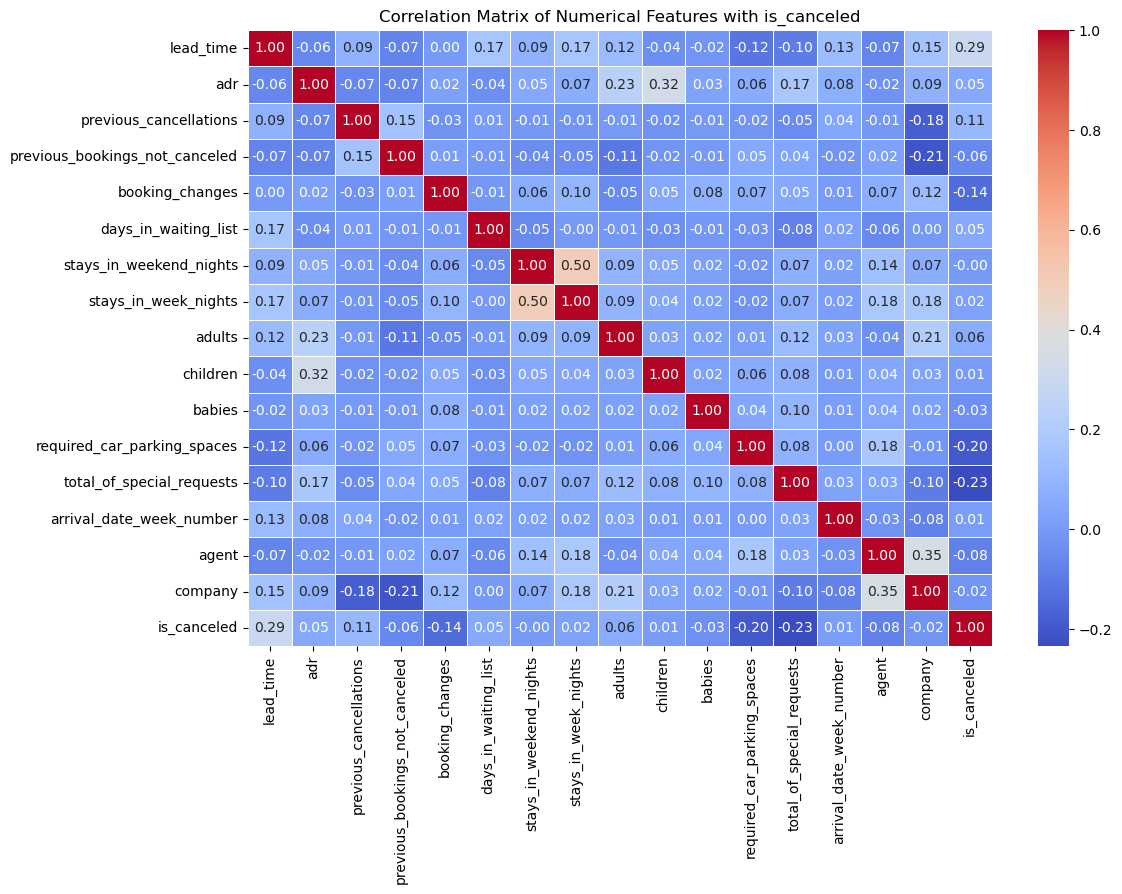

In [7]:
# Multicollinearity and correlation with target variable
# Compute correlation matrix for numerical features
corr_matrix = df[numerical_features + ["is_canceled"]].corr()

# Plot correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features with is_canceled")
plt.show()

To improve model focus and reduce noise, we refine the list of numerical features based on their **correlation with the target variable (`is_canceled`)** and overall data quality:

- Features with **very low correlation** to the target (below a threshold of 0.05) are excluded, as they are unlikely to contribute meaningfully to the model. This includes:
  - `babies`
  - `children`
  - `stays_in_weekend_nights`
  - `stays_in_week_nights`
  - `arrival_date_week_number`

- The `company` column is removed due to a **very high proportion of missing values**, making it unreliable without extensive imputation or domain-specific handling.

In [8]:
# update the numerical features we will use, after checking correlation with target variable
# discarded num features: babies, children, stays_in_weekend_nights, stays_in_week_nights, arrival_date_week_number
# threshold to discard feature based on correlation tih target: correlation < 0.05
# discarding "company" due to most of observations are null

numerical_features = [
    "lead_time", "adr", "previous_cancellations",
    "previous_bookings_not_canceled", "booking_changes",
    "days_in_waiting_list", "adults","required_car_parking_spaces",
    "total_of_special_requests", "agent"
]

## Step 5: Train-Test Split
We split the dataset into training and testing sets while maintaining the class distribution using `stratify=y`.

In [9]:
X = df.drop(columns=["is_canceled"])
y = df["is_canceled"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [10]:
# it is not necessary to rebalance the dataset
y.value_counts()

is_canceled
0    75166
1    44224
Name: count, dtype: int64

**Class Balance Check**

The dataset contains approximately 75,000 non-canceled bookings and 44,000 canceled ones. While not perfectly balanced, the class distribution is **not severely skewed** (approximately 63% vs. 37%), which is typically acceptable for most classification models. Therefore, explicit rebalancing techniques such as oversampling, undersampling, or synthetic data generation are **not required at this stage**. We proceed with the original distribution and monitor model performance metrics accordingly.

## Step 6: Visualize Outliers
Boxplots are created to visually inspect the distribution and outliers in the numerical features.

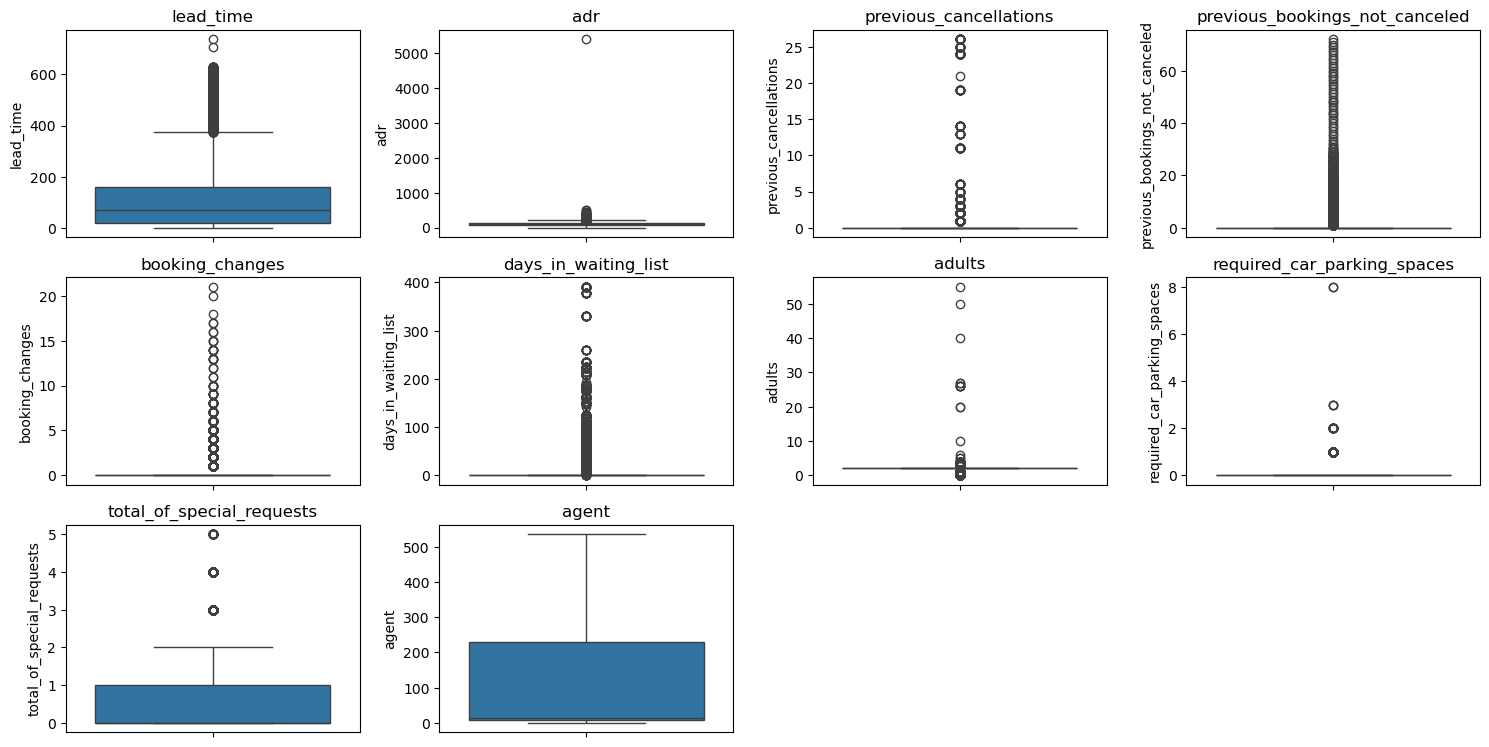

In [11]:
# Create boxplots for each numerical feature
plt.figure(figsize=(15, 10))

for i, feature in enumerate(numerical_features):
    plt.subplot(4, 4, i + 1)  # Adjust grid size based on number of features
    sns.boxplot(y=df[feature])
    plt.title(feature)

plt.tight_layout()
plt.show()


In [12]:
df[numerical_features].describe()

,lead_time,adr,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adults,required_car_parking_spaces,total_of_special_requests,agent
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000
mean,104.011416,101.831122,0.087118,0.137097,0.221124,2.321149,1.856403,0.062518,0.571363,86.693382
std,106.863097,50.535790,0.844336,1.497437,0.652306,17.594721,0.579261,0.245291,0.792798,110.774548
min,0.000000,-6.380000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,18.000000,69.290000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,9.000000
50%,69.000000,94.575000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,14.000000
75%,160.000000,126.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1.000000,229.000000
max,737.000000,5400.000000,26.000000,72.000000,21.000000,391.000000,55.000000,8.000000,5.000000,535.000000


## Step 7: Set Up Preprocessing Pipelines
Here, we define imputation, encoding, and scaling strategies. Outliers are handled using `RobustScaler` to reduce their influence.

In [13]:
categorical_features_to_ordinal = ["meal", "reserved_room_type", "assigned_room_type"]


# Define ordinal encoders with custom categories
meal_categories = [["Undefined", "SC", "HB", "BB", "FB"]]
ordinal_encoder_meals = OrdinalEncoder(categories=meal_categories)

reserved_room_categories = [sorted(df["reserved_room_type"].dropna().unique())]
assigned_room_categories = [sorted(df["assigned_room_type"].dropna().unique())]

ordinal_encoder_reserved = OrdinalEncoder(categories=reserved_room_categories, handle_unknown="use_encoded_value", unknown_value=-1)
ordinal_encoder_assigned = OrdinalEncoder(categories=assigned_room_categories, handle_unknown="use_encoded_value", unknown_value=-1)

# Define numerical preprocessing pipeline
numerical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
    ("scaler", RobustScaler())
])

# Final preprocessor with all transformations
preprocessor = ColumnTransformer([
    ("num_pipeline", numerical_pipeline, numerical_features),
    ("onehot_encoder", OneHotEncoder(sparse_output=False), [x for x in categorical_features if x not in categorical_features_to_ordinal]),
    ("ordinal_encoder_meals", ordinal_encoder_meals, ["meal"]),
    ("ordinal_encoder_reserved", ordinal_encoder_reserved, ["reserved_room_type"]),
    ("ordinal_encoder_assigned", ordinal_encoder_assigned, ["assigned_room_type"])
])

## Step 8: Final Model Pipeline
A complete scikit-learn pipeline is built combining all preprocessing and a simple base logistic regression model for classification.

In [14]:
# Complete modeling pipeline
pipe = Pipeline([
    ('preprocess', preprocessor),
    ('ml_model', LogisticRegression()) # base model
])


## Step 9: Train and Evaluate Model
The model is trained on the training set, predictions are made, and various evaluation metrics are calculated.

To optimize model performance, we conduct a **grid search** over a set of hyperparameters for two classifiers: **Logistic Regression** and **Random Forest**.

- For **Logistic Regression**, we tune the regularization strength `C`, which controls the balance between bias and variance. A wide range from very small (`0.001`) to large (`100`) is tested.
- For **Random Forest**, we adjust key structural parameters:
  - `n_estimators`: number of trees in the forest
  - `max_depth`: maximum depth of each tree
  - `min_samples_split` and `min_samples_leaf`: to control overfitting and leaf size

Both models are configured with `class_weight='balanced'` to handle the mild class imbalance in the dataset.

To evaluate models, we use **5-fold cross-validation** and score them based on **recall**.

### Why Prioritize Recall?

In this context, our goal is to **predict booking cancellations as early as possible**, so the hotel can act on them (e.g., reallocate rooms, follow up with customers). To do this effectively, it's critical to minimize **false negatives**—i.e., avoid missing actual cancellations.

**Error Tradeoff**

- **False Positive (FP)**  
  *Prediction:* Booking will be canceled  
  *Reality:* Booking is not canceled  
  **Impact:** Some operational noise (e.g., sending extra emails or reallocating a room), but generally manageable.

- **False Negative (FN)**  
  *Prediction:* Booking will not be canceled  
  *Reality:* Booking is canceled  
  **Impact:** Missed opportunity to resell the room. This can result in **lost revenue**, especially in high-demand periods. The financial cost can scale significantly.

We prioritize **recall** to capture as many actual cancellations as possible—even if it means some non-canceled bookings are flagged. This approach is justified because:

- The **cost of undetected cancellations** is higher than the inconvenience of false alerts.
- **Proactive measures** can be triggered based on predictions, benefiting the business operationally.

By optimizing for recall, the model supports better inventory management and revenue protection, which are key goals in hotel operations.

In [15]:
# Hypeparameter tuning
param_grid = [
    {
        'ml_model': [LogisticRegression(class_weight='balanced', solver='liblinear')],
        'ml_model__C': [0.001, 0.01, 0.1, 1, 10, 100]
    },
    {
        'ml_model': [RandomForestClassifier(class_weight='balanced')],
        'ml_model__n_estimators': [100, 200, 300],
        'ml_model__max_depth': [None, 10, 20],
        'ml_model__min_samples_split': [2, 5],
        'ml_model__min_samples_leaf': [1, 2]
    }
]


grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring="recall", verbose=4, n_jobs=6)
total_models = len(param_grid) * 5  # 5-fold cross-validation
print(f"Total models to train: {total_models}")
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
print("Best Model:", best_model)
print("Best hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Total models to train: 10
Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV 2/5] END ml_model=LogisticRegression(class_weight='balanced', solver='liblinear'), ml_model__C=0.001;, score=0.722 total time=   1.4s
[CV 3/5] END ml_model=LogisticRegression(class_weight='balanced', solver='liblinear'), ml_model__C=0.001;, score=0.728 total time=   1.4s
[CV 1/5] END ml_model=LogisticRegression(class_weight='balanced', solver='liblinear'), ml_model__C=0.001;, score=0.718 total time=   1.8s
[CV 4/5] END ml_model=LogisticRegression(class_weight='balanced', solver='liblinear'), ml_model__C=0.001;, score=0.706 total time=   1.6s
[CV 5/5] END ml_model=LogisticRegression(class_weight='balanced', solver='liblinear'), ml_model__C=0.001;, score=0.713 total time=   1.5s
[CV 1/5] END ml_model=LogisticRegression(class_weight='balanced', solver='liblinear'), ml_model__C=0.01;, score=0.738 total time=   2.2s
[CV 3/5] END ml_model=LogisticRegression(class_weight='balanced', solver='liblinear')

/home/sge/anaconda3/envs/miba-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 2/5] END ml_model=RandomForestClassifier(class_weight='balanced'), ml_model__max_depth=None, ml_model__min_samples_leaf=1, ml_model__min_samples_split=2, ml_model__n_estimators=200;, score=0.778 total time=  29.9s
[CV 3/5] END ml_model=RandomForestClassifier(class_weight='balanced'), ml_model__max_depth=None, ml_model__min_samples_leaf=1, ml_model__min_samples_split=2, ml_model__n_estimators=200;, score=0.766 total time=  29.1s
[CV 5/5] END ml_model=RandomForestClassifier(class_weight='balanced'), ml_model__max_depth=None, ml_model__min_samples_leaf=1, ml_model__min_samples_split=2, ml_model__n_estimators=200;, score=0.763 total time=  29.1s
[CV 4/5] END ml_model=RandomForestClassifier(class_weight='balanced'), ml_model__max_depth=None, ml_model__min_samples_leaf=1, ml_model__min_samples_split=2, ml_model__n_estimators=200;, score=0.762 total time=  29.6s
[CV 1/5] END ml_model=RandomForestClassifier(class_weight='balanced'), ml_model__max_depth=None, ml_model__min_samples_leaf=1, m

In [16]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     15033
           1       0.80      0.79      0.79      8845

    accuracy                           0.85     23878
   macro avg       0.84      0.83      0.84     23878
weighted avg       0.85      0.85      0.85     23878



## Step 10: Save the Trained Model
The entire pipeline (preprocessing + model) is saved using joblib for later deployment in the streamlit prototype.

In [17]:
# Save the best estimator from grid search
best_model = grid_search.best_estimator_
joblib.dump(best_model, "best_model_pipeline.pkl")
print("Best model saved as 'best_model_pipeline.pkl'")

Best model saved as 'best_model_pipeline.pkl'


In [18]:
# Load the saved model
loaded_pipe = joblib.load("logistic_regression_pipeline.pkl")

# Test prediction on new data
y_pred_proba = loaded_pipe.predict_proba(X_test[:5])  # Get probabilities for first 5 samples
print("Predicted Probabilities:\n", y_pred_proba)


Predicted Probabilities:
 [[0.84034584 0.15965416]
 [0.69988194 0.30011806]
 [0.60424471 0.39575529]
 [0.99537055 0.00462945]
 [0.67101413 0.32898587]]
